This script is used to produce the plots from our OpenAI Gym experiments in our
paper. If you'd like to use this script on your own data, check the README,
and follow the same approach used in the `1_grid_search` section.

# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

from qscaled.wandb_utils.one_seed_per_run import ExampleOneSeedPerRunCollector
from qscaled.utils.zip_handler import fetch_zip_data
from qscaled.utils.configs import FittedConfig
from qscaled.core.preprocessing import bootstrap_crossings, get_envs, get_utds
from qscaled.utils.plot_utils import set_theme
from qscaled.core.grid_search import linear_fit
from qscaled.core.fitted import learning_curves, data_efficiency, budget

In [3]:
wandb_collect = False

config_input = dict(
    sweep_name='gym_sweep',
    sweep_slope_type='shared',
    max_returns={
        'HalfCheetah-v4': 9800,
        'Walker2d-v4': 4950,
        'Ant-v4': 6625,
        'Humanoid-v4': 6450,
    },
    returns_key='episode/return',
    thresholds=1000 - np.logspace(np.log10(1000 - 300), np.log10(1000 - 800), 10),
    model_size=1.5e5,  # Number of critic parameters
    budget_delta=4e9,
    budget_extrapolate_top_k=2,
)

if wandb_collect:
    fitted_collector = ExampleOneSeedPerRunCollector(
        'prestonfu', 'crl', wandb_tags=['sac_optimal_250210']
    )
    baseline_collector = ExampleOneSeedPerRunCollector(
        'prestonfu', 'crl', wandb_tags=['sac_grid_250207_bl_utd2.0']
    )

    trim_input = dict(
        num_seeds=8, compare_metric=config_input['returns_key'], compare_how='max', verbose=True
    )
    fitted_collector.remove_short(0.95)
    baseline_collector.remove_short(0.95)
    fitted_collector.trim(**trim_input)
    baseline_collector.trim(**trim_input)

else:
    fitted_collector = baseline_collector = None


fitted_config = FittedConfig(
    name='gym_ours',
    wandb_collector=fitted_collector,
    **config_input,
)

baseline_config = FittedConfig(
    name='gym_baseline_utd2',
    wandb_collector=baseline_collector,
    **config_input,
)

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

In [4]:
ours_df = fetch_zip_data(fitted_config, use_cached=True)
ours_df = bootstrap_crossings(
    ours_df, fitted_config.thresholds, fitted_config.name, use_cached=False
)
baseline_df = fetch_zip_data(baseline_config, use_cached=True)
baseline_df = bootstrap_crossings(
    baseline_df, baseline_config.thresholds, baseline_config.name, use_cached=False
)
envs = get_envs(ours_df)
utds = get_utds(ours_df)

100%|██████████| 28/28 [00:02<00:00, 11.05it/s]


Average standard deviation across all conditions: 39646.91


100%|██████████| 28/28 [00:02<00:00, 10.92it/s]


Average standard deviation across all conditions: 45185.08


# Visualization

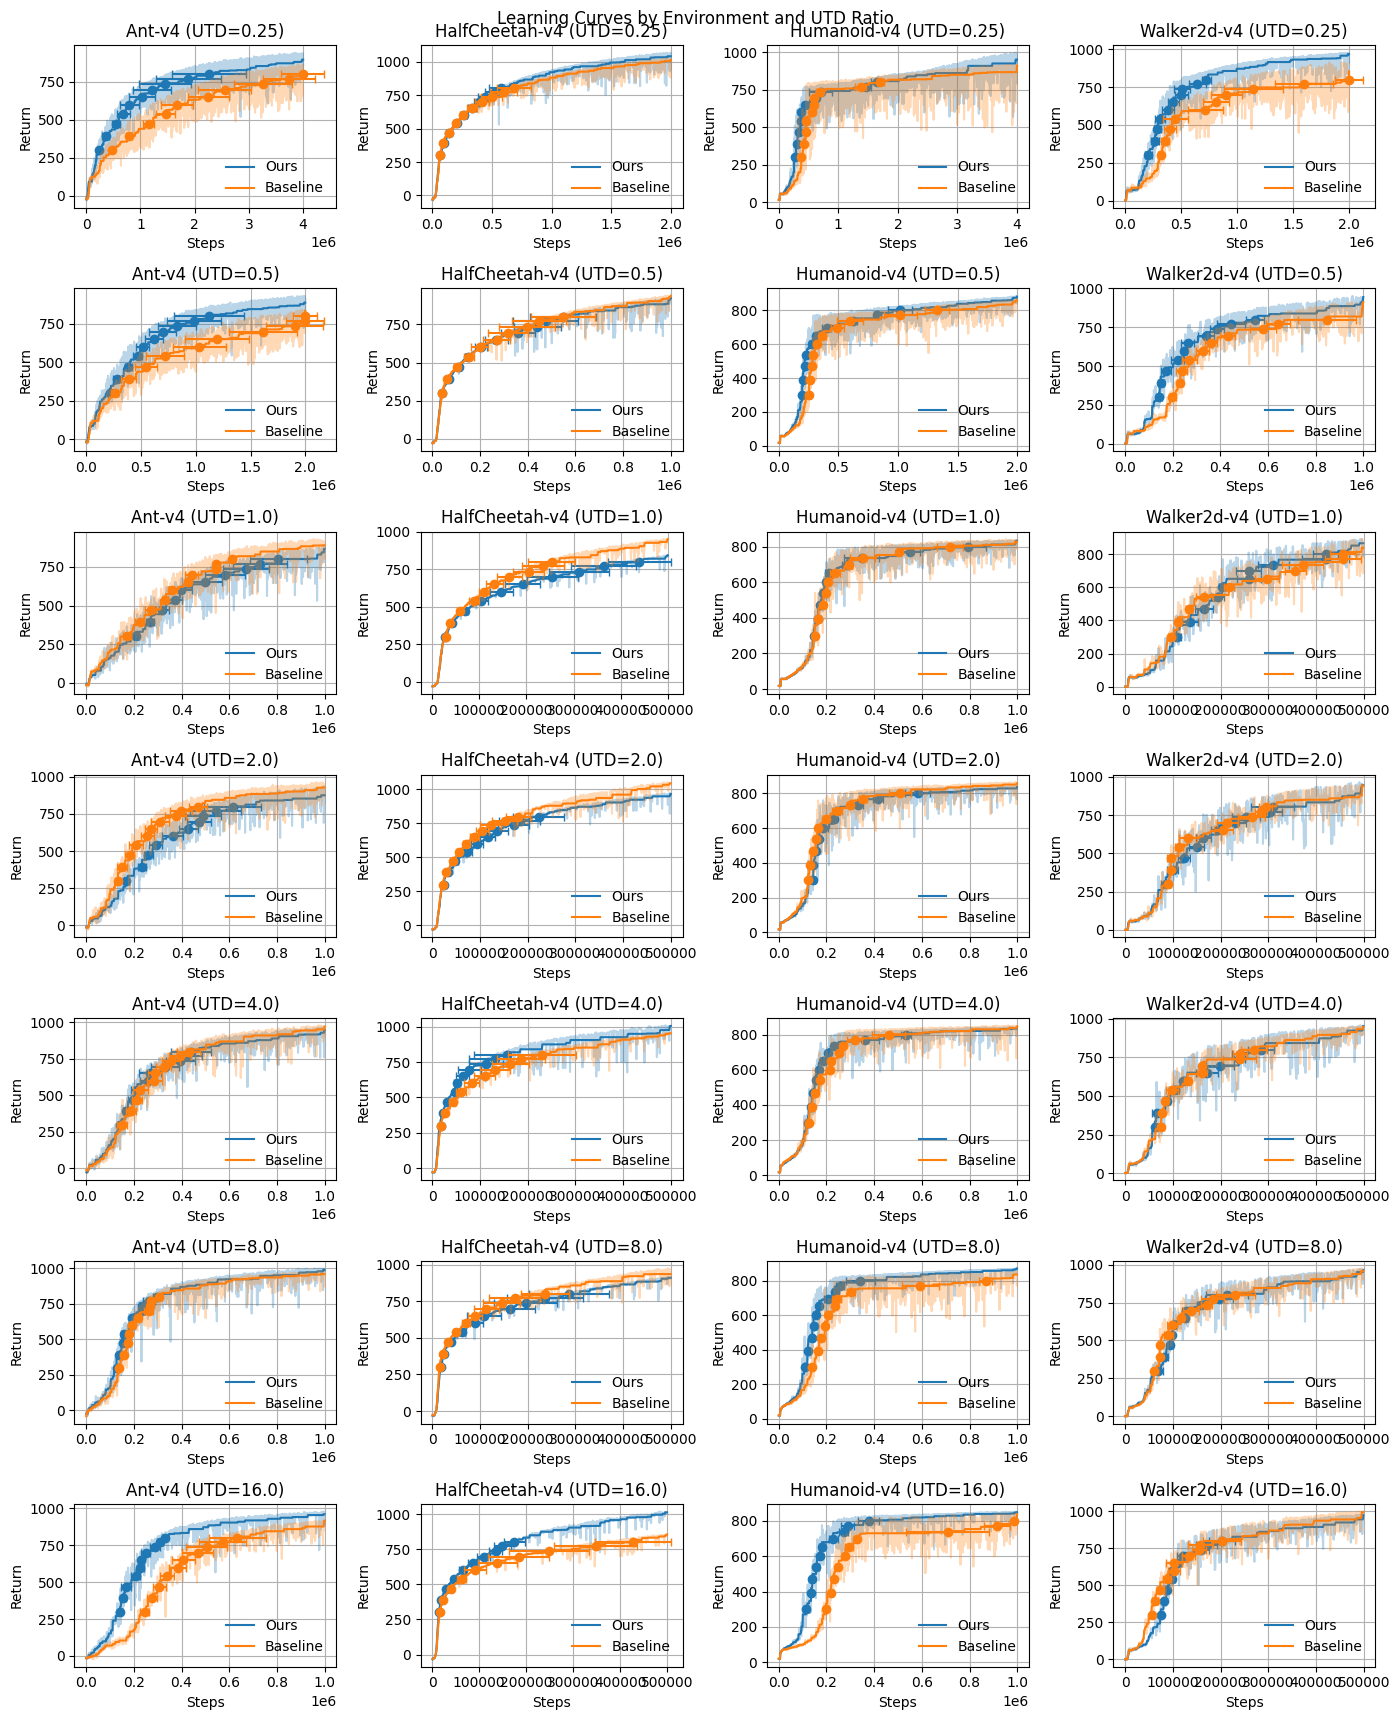

In [5]:
learning_curves.plot_per_env_utd(ours_df, baseline_df, fitted_config.thresholds)

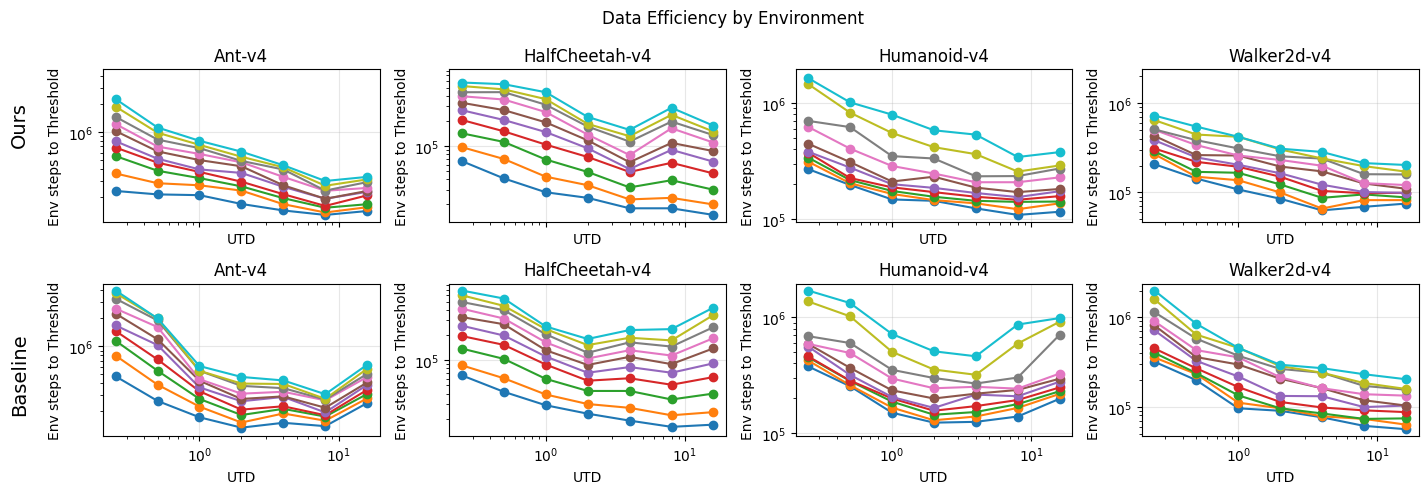

In [6]:
ours_env_data_efficiency_dict = data_efficiency.compute_data_efficiency_per_env(ours_df, envs)
baseline_env_data_efficiency_dict = data_efficiency.compute_data_efficiency_per_env(
    baseline_df, envs
)
data_efficiency.plot_data_efficiency_per_env(
    ours_env_data_efficiency_dict, baseline_env_data_efficiency_dict, envs
)

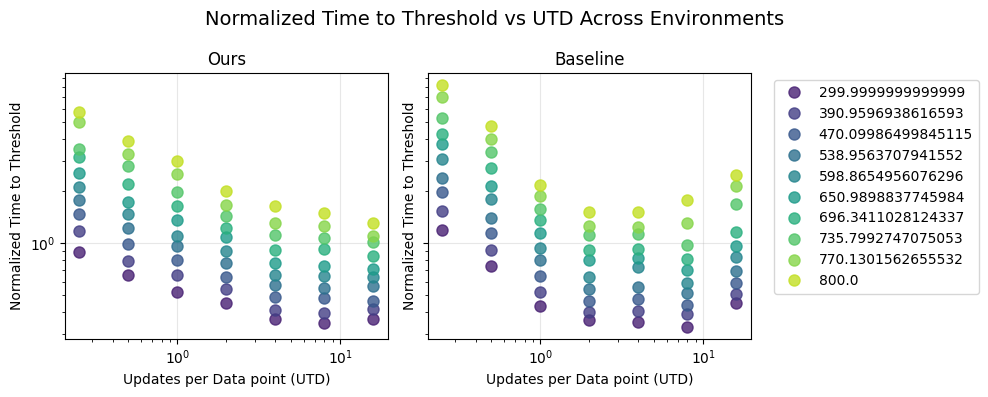

In [7]:
ours_normalized_times_all, ours_mean_normalized_times, ours_median_median = (
    data_efficiency.compute_normalized_times(ours_env_data_efficiency_dict, envs)
)
baseline_normalized_times_all, baseline_mean_normalized_times, baseline_median_median = (
    data_efficiency.compute_normalized_times(baseline_env_data_efficiency_dict, envs)
)
data_efficiency.plot_data_efficiency_averaged(
    ours_mean_normalized_times, baseline_mean_normalized_times, utds, fitted_config.thresholds
)

# Asymptotic data efficiency fit

In [8]:
ours_data_pareto_fits = data_efficiency.make_data_pareto_fits(
    ours_mean_normalized_times,
    utds,
    len(fitted_config.thresholds),
    output_dir='../outputs',
    save_name=fitted_config.name,
)
baseline_data_pareto_fits = data_efficiency.make_data_pareto_fits(
    baseline_mean_normalized_times,
    utds,
    len(fitted_config.thresholds),
    output_dir='../outputs',
    save_name=baseline_config.name,
)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/preston/value-scaling-workflow-private/qscaled/utils/power_law.py:6: RuntimeWarning: invalid value encountered in power
  return c + (x / (b + 1e-12)) ** (-a)
/home/preston/value-scaling-workflow-private/qscaled/utils/power_law.py:6: RuntimeWarning: overflow encountered in power
  return c + (x / (b + 1e-12)) ** (-a)
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
100%|██████████| 10/10 [00:14<00:00,  1.42s/it]


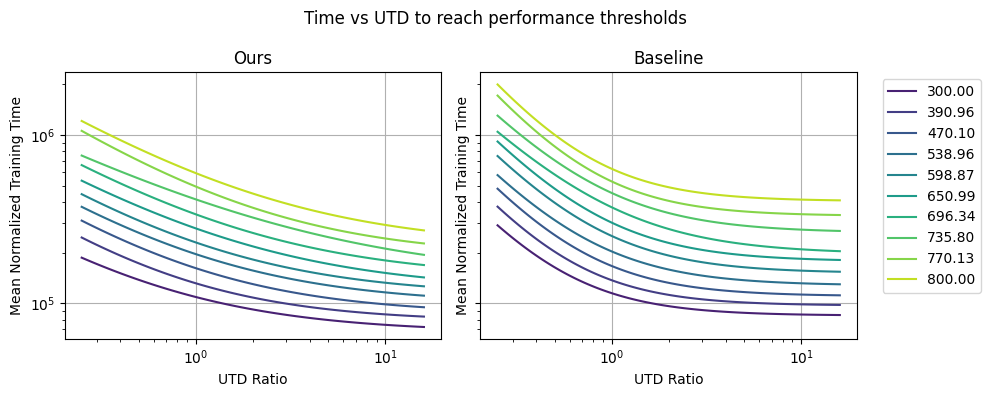

In [9]:
data_efficiency.plot_utd_data_pareto_fits(
    ours_data_pareto_fits,
    ours_median_median,
    baseline_data_pareto_fits,
    baseline_median_median,
    utds,
    fitted_config.thresholds,
)

# Final plots

In [10]:
set_theme()

Fits using threshold 800.0
Ours: D_J = 2.17e+05 * (1 + (σ/2.29)**(-0.70))


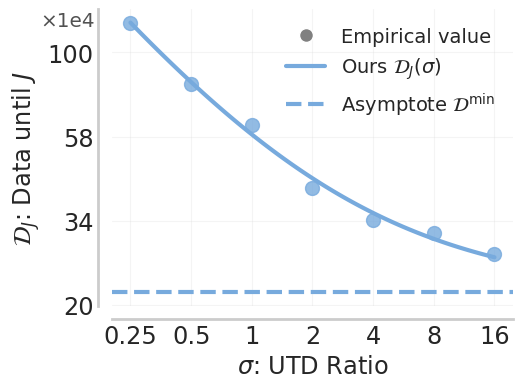

Fits using threshold 800.0
Ours: D_J = 2.17e+05 * (1 + (σ/2.29)**(-0.70))
Baseline: D_J = 4.04e+05 * (1 + (σ/0.95)**(-1.41))


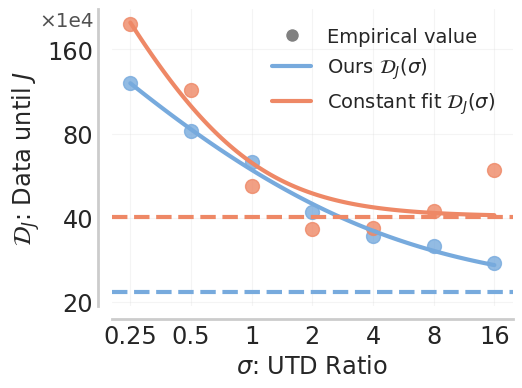

In [11]:
utd_data_pareto_fit_input = dict(
    ours_fits=ours_data_pareto_fits,
    ours_normalized_times_all=ours_normalized_times_all,
    ours_median_median=ours_median_median,
    baseline_fits=baseline_data_pareto_fits,
    baseline_normalized_times_all=baseline_normalized_times_all,
    baseline_median_median=baseline_median_median,
    utds=utds,
    thresholds=fitted_config.thresholds,
    threshold_idx=-1,
    yscale='1e4',
)

data_efficiency.plot_clean_utd_data_pareto_fit(
    **utd_data_pareto_fit_input, ylim=(20e4, 100e4), show_baseline=False
)
data_efficiency.plot_clean_utd_data_pareto_fit(
    **utd_data_pareto_fit_input, ylim=(20e4, 160e4), show_baseline=True
)

Fits using threshold 800.0


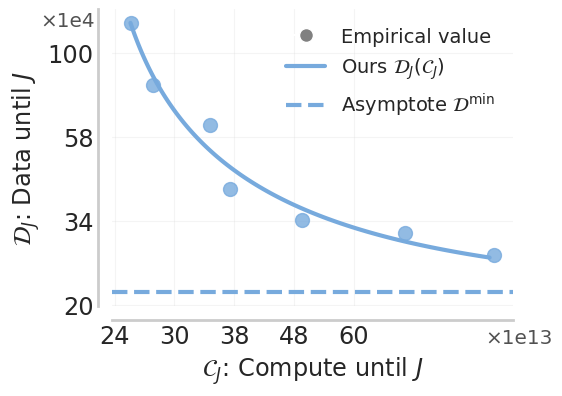

Fits using threshold 800.0


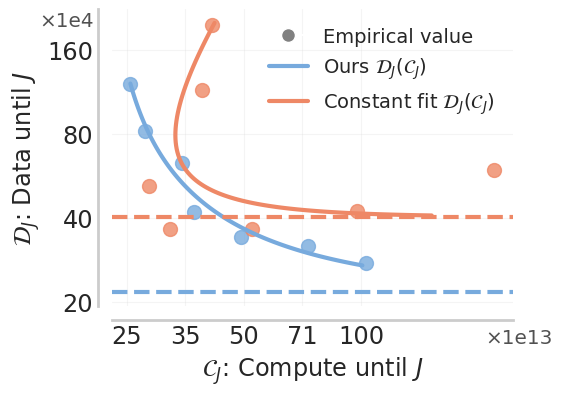

In [12]:
utd_to_batch_size_fn = linear_fit.get_fit_mean_batch_size(
    envs, '../outputs', fitted_config.sweep_name, fitted_config.sweep_slope_type
)
compute_data_pareto_fit_input = dict(
    ours_fits=ours_data_pareto_fits,
    ours_normalized_times_all=ours_normalized_times_all,
    ours_median_median=ours_median_median,
    baseline_fits=baseline_data_pareto_fits,
    baseline_normalized_times_all=baseline_normalized_times_all,
    baseline_median_median=baseline_median_median,
    utd_to_batch_size_fn=utd_to_batch_size_fn,
    model_size=fitted_config.model_size,
    utds=utds,
    thresholds=fitted_config.thresholds,
    threshold_idx=-1,
    xscale='1e13',
    yscale='1e4',
)

data_efficiency.plot_clean_compute_data_pareto_fit(
    **compute_data_pareto_fit_input, show_baseline=False, xlim=(24e13, 60e13), ylim=(20e4, 100e4)
)
data_efficiency.plot_clean_compute_data_pareto_fit(
    **compute_data_pareto_fit_input, show_baseline=True, xlim=(25e13, 100e13), ylim=(20e4, 160e4)
)

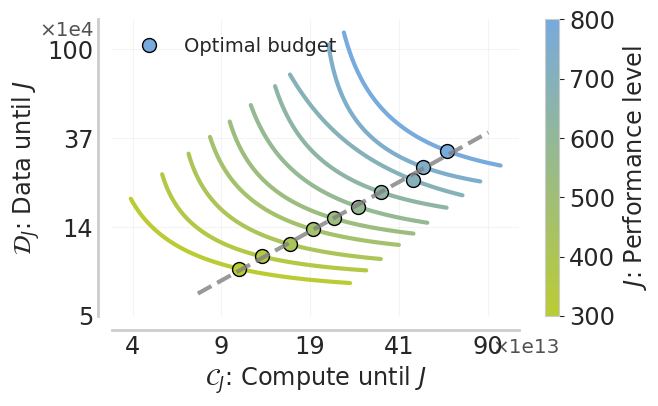

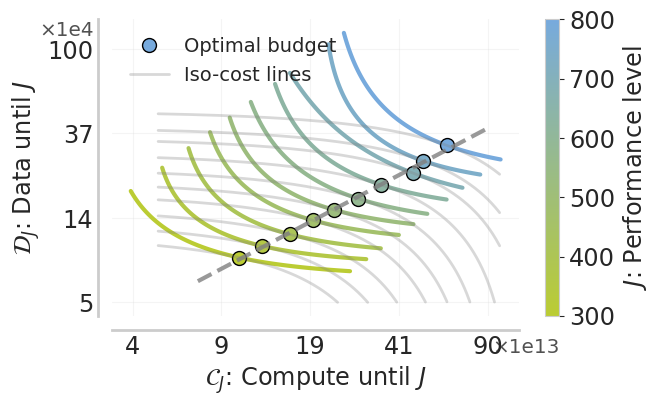

In [13]:
compute_data_isoperformance_input = dict(
    fits=ours_data_pareto_fits,
    normalized_times_all=ours_normalized_times_all,
    median_median=ours_median_median,
    thresholds=fitted_config.thresholds,
    utd_to_batch_size_fn=utd_to_batch_size_fn,
    utds=utds,
    model_size=fitted_config.model_size,
    delta=fitted_config.budget_delta,
    xlim=(4e13, 90e13),
    ylim=(5e4, 100e4),
    xscale='1e13',
    yscale='1e4',
)

min_points_compute, min_points_data, min_points_utd = budget.plot_compute_data_isoperformance(
    **compute_data_isoperformance_input
)
_ = budget.plot_compute_data_isoperformance(
    **compute_data_isoperformance_input,
    show_isocost=True,
    isocost_xlim=(5e13, 100e13),
    isocost_ylim=(5e4, 100e4),
)

σ* = 2.62e-09 × F_J^0.62


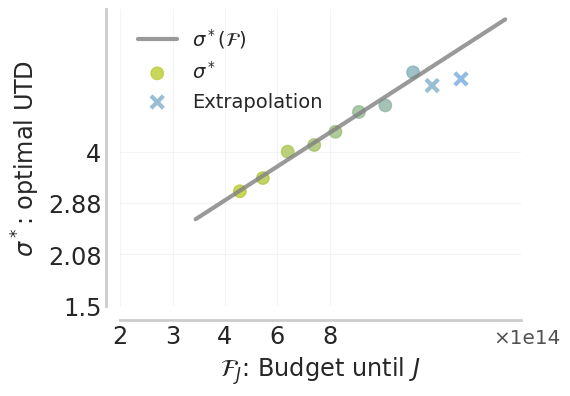

In [14]:
budget.plot_budget_extrapolation(
    min_points_compute,
    min_points_data,
    min_points_utd,
    delta=fitted_config.budget_delta,
    thresholds=fitted_config.thresholds,
    n_extrapolate_points=fitted_config.budget_extrapolate_top_k,
    xlim=(2e14, 8e14),
    xscale='1e14',
    ylim=(1.5, 4),
)